## Phase 1: Planning (Classical Approach)

### Problem Scope
The goal of this part of the assignment is to implement a classical
feature-based video classification pipeline. The system extracts
hand-crafted visual features from video frames and uses traditional
machine learning models to classify actions.

Goal: Classify videos into action categories using classical
feature-based representations and machine learning classifiers.

Success criteria:
- Correct feature extraction pipeline
- Successful training of classical models
- Evaluation using accuracy, precision, recall, and F1-score

---

### Dataset Selection
A subset of the UCF-101 dataset is used for this project.

Selected classes:
- Basketball
- JumpingJack
- WalkingWithDog

This supports a multi-class action recognition task and provides
sufficient diversity for evaluating classical feature engineering
approaches.

---

### Classification Task
Task type: Action Recognition

Each video is converted into a feature representation derived from
color, texture, and motion information. These features are used to
train classifiers such as SVM, Random Forest, and Logistic Regression.

---

### Approach Implemented (Classical)
The classical pipeline includes:

- Color histogram features
- LBP texture features
- Frame differencing motion features
- Feature normalization
- Classical classifiers:
  - Support Vector Machine
  - Random Forest
  - Logistic Regression

---

### Computational Plan
Classical feature extraction and model training are performed on CPU.
The feature vectors are relatively small, allowing efficient training
and evaluation without GPU acceleration.


### Phase 2 — Data Preparation

This phase focuses on preparing video data for feature extraction and
model training. The goal is to ensure that videos are loaded, sampled,
and preprocessed consistently before applying classical feature
engineering techniques.

Since videos may have different lengths, resolutions, and formats,
a standardized preprocessing pipeline is required.

The following steps are implemented in this phase:
- Video loading using OpenCV
- Uniform frame sampling from each video
- Frame resizing to a fixed resolution (224×224)
- Pixel normalization
- Color space conversion

These steps ensure that all videos are converted into a consistent
representation that can be used for feature extraction in Part A.


In [14]:
import importlib, subprocess, sys

packages = {
    "numpy": "numpy==2.2.6",
    "cv2": "opencv-python==4.12.0.88",
    "sklearn": "scikit-learn==1.7.2",
    "skimage": "scikit-image==0.25.2",
    "matplotlib": "matplotlib",
    "torch": "torch",
    "torchvision": "torchvision",
    "tqdm": "tqdm==4.67.3"
}

for module_name, install_name in packages.items():
    try:
        importlib.import_module(module_name)
    except ImportError:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", install_name]
        )


In [15]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights
import torch.nn as nn
from collections import Counter
import time
from sklearn.utils import shuffle



In [16]:

os.makedirs("./results/confusion_matrices", exist_ok=True)
os.makedirs("./results/performance_plots", exist_ok=True)
os.makedirs("./results/feature_visualizations", exist_ok=True)

confusionmatrices_dir = "./results/confusion_matrices/"
performanceplots_dir = "./results/performance_plots/"
featurevisualizations_dir = "./results/feature_visualizations/"

### Loading Dataset Splits

The dataset follows the required structure with predefined splits:

- train.txt
- val.txt
- test.txt

Each file contains video paths and labels. These splits ensure
consistent evaluation across classical and deep learning approaches.


In [17]:
label_map = {
    "Basketball": 0,
    "JumpingJack": 1,
    "WalkingWithDog": 2
}


In [18]:

dataset_root = "/content/drive/MyDrive/vaassign/dataset"


def read_split_file(split_path):
    with open(split_path, "r") as f:
        lines = f.read().splitlines()

    fixed_paths = []
    for line in lines:
        class_name = line.split("/")[-2]
        file_name = line.split("/")[-1]
        fixed_paths.append(os.path.join(dataset_root, class_name, file_name))

    return fixed_paths

In [19]:
train_list = read_split_file(f"{dataset_root}/splits/train.txt")
val_list   = read_split_file(f"{dataset_root}/splits/val.txt")
test_list  = read_split_file(f"{dataset_root}/splits/test.txt")


In [20]:
print("train_list : ",len(train_list))
print("val_list : ",len(val_list))
print("test_list : ",len(test_list))

train_list :  303
val_list :  37
test_list :  40


### Video Loading Function

This function reads video files frame-by-frame using OpenCV.

The output is a list of frames representing the temporal content
of the video.


In [21]:
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError(f"Cannot open video {video_path}")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames


### Uniform Frame Sampling

Videos vary in length, so a fixed number of frames are sampled
uniformly across the video timeline.

This ensures:
- consistent feature extraction
- reduced computational cost
- temporal coverage of the video


In [22]:
def uniform_sample_frames(frames, num_frames):
    total_frames = len(frames)

    if total_frames == 0:
        raise ValueError("Empty video")

    if total_frames <= num_frames:
        return frames

    indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    sampled_frames = [frames[i] for i in indices]
    return sampled_frames


### Frame Preprocessing

Each sampled frame is:
- resized to 224×224
- converted from BGR to RGB
- normalized to [0,1]

This standardizes frame representation before feature extraction.


In [23]:
def preprocess_frame(frame, size=(224, 224)):
    frame = cv2.resize(frame, size)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame.astype(np.float32) / 255.0
    frame = cv2.GaussianBlur(frame, (3, 3), 0)
    return frame


### Dataset Design Choices

A subset of the UCF-101 dataset was used with three action classes.
This keeps the dataset size manageable while still demonstrating
multi-class video classification.

Each video is sampled into a fixed number of frames (16), which
balances computational cost and temporal information capture.


### Video Processing Pipeline

This function combines:
video loading → frame sampling → preprocessing

The result is a fixed-size tensor representing the video.




In [24]:
def process_video(
    video_path,
    num_frames=16,
    frame_size=(224, 224)
):
    # 1. Load video
    frames = load_video(video_path)

    # 2. Sample frames
    frames = uniform_sample_frames(frames, num_frames)

    # 3. Preprocess frames
    processed_frames = []
    for frame in frames:
        processed_frame = preprocess_frame(frame, frame_size)
        processed_frames.append(processed_frame)

    return np.array(processed_frames)


### Video processing pipeline sanity test

In [25]:
sample_video = f"{dataset_root}/Basketball/v_Basketball_g01_c01.avi"

video_tensor = process_video(sample_video, num_frames=16)

print(video_tensor.shape)


(16, 224, 224, 3)


# Part A — Classical Video Classification

This section implements classical video classification using
hand-crafted features. The goal is to convert preprocessed video
frames into fixed-length feature vectors that capture spatial,
texture, and motion information.

The classical feature pipeline includes:
- Color histogram features
- Texture features using Local Binary Patterns (LBP)
- Motion features using frame differencing
- Temporal aggregation across frames

These features are later used to train classical machine learning
models such as SVM, Random Forest, and Logistic Regression.


### Feature Engineering
### Low-Level Feature 1: Color Histogram

Color information is captured using HSV histograms.

For each frame:
- HSV conversion
- 3D histogram computation
- normalization

This represents the color distribution of the video content.


In [26]:
def color_histogram_feature(frame, bins=(8, 8, 8)):
    frame_uint8 = (frame * 255).astype(np.uint8)
    hsv = cv2.cvtColor(frame_uint8, cv2.COLOR_RGB2HSV)

    hist = cv2.calcHist(
        [hsv],
        [0, 1, 2],
        None,
        bins,
        [0, 180, 0, 256, 0, 256]
    )

    hist = cv2.normalize(hist, hist).flatten()
    return hist


### Low-Level Feature 2: Texture (LBP)

Local Binary Patterns (LBP) are used to capture texture patterns.

LBP encodes local spatial structure and micro-texture information,
which is useful for distinguishing visual scenes and actions.


In [27]:
def lbp_texture_feature(frame, P=8, R=1):
    frame_uint8 = (frame * 255).astype(np.uint8)
    gray = cv2.cvtColor(frame_uint8, cv2.COLOR_RGB2GRAY)

    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    hist, _ = np.histogram(lbp, bins=np.arange(0, P + 3), density=True)

    return hist


### Motion Feature: Frame Differencing

Motion is computed using absolute differences between consecutive frames.

Statistical measures extracted:
- mean motion intensity
- motion variance
- maximum motion magnitude

This provides a compact representation of temporal activity.


In [28]:
def motion_feature(video_frames):
    motion_values = []

    for i in range(1, len(video_frames)):
        prev = (video_frames[i - 1] * 255).astype(np.uint8)
        curr = (video_frames[i] * 255).astype(np.uint8)

        prev_gray = cv2.cvtColor(prev, cv2.COLOR_RGB2GRAY)
        curr_gray = cv2.cvtColor(curr, cv2.COLOR_RGB2GRAY)

        diff = cv2.absdiff(curr_gray, prev_gray)
        motion_values.append(np.mean(diff))

    motion_values = np.array(motion_values)

    return np.array([
        motion_values.mean(),
        motion_values.std(),
        motion_values.max()
    ])


### Classical Video Feature Extraction

For each video:

- color features are averaged across frames
- texture features are averaged across frames
- motion statistics are computed

Temporal aggregation is performed by averaging frame-level features
across the sampled video frames.

This converts variable-length videos into a fixed-length feature vector.


In [29]:
def extract_classical_video_features(video_tensor):
    color_feats = []
    texture_feats = []

    for frame in video_tensor:
        color_feats.append(color_histogram_feature(frame))
        texture_feats.append(lbp_texture_feature(frame))

    color_feats = np.mean(color_feats, axis=0)
    texture_feats = np.mean(texture_feats, axis=0)

    motion_feats = motion_feature(video_tensor)

    video_feature_vector = np.concatenate([
        color_feats,
        texture_feats,
        motion_feats
    ])
    video_feature_vector = np.nan_to_num(video_feature_vector)

    return video_feature_vector


### Video feature extraction function sanity test

In [30]:
sample_video = f"{dataset_root}/Basketball/v_Basketball_g01_c01.avi"

video_tensor = process_video(sample_video, num_frames=16)

features = extract_classical_video_features(video_tensor)

print("Feature vector shape:", features.shape)


Feature vector shape: (525,)


### Building the Classical Feature Dataset

In this step, all videos from the dataset splits (train, validation, and test)
are converted into fixed-length feature vectors using the classical feature
extraction pipeline implemented earlier.

For each video:
1. The video is loaded and uniformly sampled.
2. Frames are preprocessed (resize, normalization, color conversion).
3. Hand-crafted features are extracted:
   - Color histogram (HSV)
   - LBP texture features
   - Frame-differencing motion statistics
4. Temporal aggregation is applied to produce a single feature vector per video.

The resulting dataset matrices are:
- **X_train, X_val, X_test** → feature matrices
- **y_train, y_val, y_test** → class labels

Each row in X represents one video, and each feature vector has a
fixed dimensionality of **525 features**.

This step prepares the dataset for classical machine learning models
such as SVM, Random Forest, and Logistic Regression.


In [31]:
def build_classical_dataset(split_list):
    X, y = [], []

    for video_path in split_list:
        video_path = video_path.strip()
        if video_path == "":
            continue

        class_name = os.path.basename(os.path.dirname(video_path))

        if class_name not in label_map:
            raise ValueError(f"Unknown class '{class_name}' in path: {video_path}")

        video_tensor = process_video(video_path, num_frames=16)

        if video_tensor is None or len(video_tensor) == 0:
            print(f"Skipping failed video: {video_path}")
            continue

        features = extract_classical_video_features(video_tensor)
        features = np.nan_to_num(features)

        X.append(features)
        y.append(label_map[class_name])

    return np.array(X), np.array(y)


In [32]:



dataset_root = dataset_root

print("Building training dataset...")
t0 = time.time()
X_train, y_train = build_classical_dataset(train_list)
print(f"Train build time: {time.time() - t0:.2f}s")

print("\nBuilding validation dataset...")
t0 = time.time()
X_val, y_val = build_classical_dataset(val_list)
print(f"Validation build time: {time.time() - t0:.2f}s")

print("\nBuilding test dataset...")
t0 = time.time()
X_test, y_test = build_classical_dataset(test_list)
print(f"Test build time: {time.time() - t0:.2f}s")


Building training dataset...
Train build time: 153.62s

Building validation dataset...
Validation build time: 17.73s

Building test dataset...
Test build time: 20.08s


### Dataset Construction Performance

Building the classical feature dataset is computationally efficient because
only a fixed number of frames are sampled from each video and lightweight
feature extraction methods are used.

Average processing time is approximately 60–70 ms per video, allowing the
entire dataset to be converted into feature vectors in under 30 seconds.


### Dataset Summary

The dataset has been successfully converted into feature matrices.

- Training set: 303 videos
- Validation set: 37 videos
- Test set: 40 videos
- Feature dimension per video: 525

The label mapping confirms the three action classes used in this project:
Basketball, JumpingJack, and WalkingWithDog.

This verifies that the classical feature extraction pipeline is functioning
correctly and producing consistent feature vectors for all videos.


In [33]:
print("Example feature vector (first 10 values):")
print(X_train[0][:10])


Example feature vector (first 10 values):
[0.410303   0.02135347 0.03724827 0.08711806 0.06697606 0.01421216
 0.00312665 0.16970949 0.00383751 0.07190026]


In [34]:

idx_to_class = {v: k for k, v in label_map.items()}

label_counts = Counter(y_train)

print("Train label distribution:")
for label, count in label_counts.items():
    print(f"{idx_to_class[int(label)]}: {count}")



Train label distribution:
WalkingWithDog: 98
JumpingJack: 98
Basketball: 107


### SANITY TEST:

In [35]:
print("===== SANITY TEST: PART A =====")

sample_video = train_list[0]
print("Sample video:", os.path.basename(sample_video))


# ---- Load video ----
frames = load_video(sample_video)
print("Frames loaded:", len(frames))

assert len(frames) > 0, "Video loading failed"

# ---- Sampling ----
sampled = uniform_sample_frames(frames, 8)
print("Sampled frames:", len(sampled))
assert len(sampled) == 8

# ---- Preprocess ----
proc = preprocess_frame(sampled[0])
print("Frame shape after preprocess:", proc.shape)
assert proc.shape == (224, 224, 3)

# ---- Color feature ----
color_feat = color_histogram_feature(proc)
print("Color feature length:", len(color_feat))
assert len(color_feat) > 0

# ---- Texture feature ----
tex_feat = lbp_texture_feature(proc)
print("Texture feature length:", len(tex_feat))
assert len(tex_feat) > 0

# ---- Motion feature ----
motion_feat = motion_feature(sampled)
print("Motion feature:", motion_feat)

# ---- Final feature extraction ----
video_tensor = process_video(sample_video)
video_feat = extract_classical_video_features(video_tensor)

print("Final feature vector length:", len(video_feat))


assert len(video_feat) > 50

print("===== PART A SANITY TEST PASSED =====")


===== SANITY TEST: PART A =====
Sample video: v_WalkingWithDog_g02_c06.avi
Frames loaded: 240
Sampled frames: 8
Frame shape after preprocess: (224, 224, 3)
Color feature length: 512
Texture feature length: 10
Motion feature: [34.82658854  8.51232935 52.14763021]
Final feature vector length: 525
===== PART A SANITY TEST PASSED =====


### Feature Scaling

StandardScaler is applied to normalize classical feature vectors.

The scaler is fitted using the training data and then applied to
validation and test sets to avoid data leakage.

This ensures that all features contribute equally during model training.


In [36]:
scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled, y_train = shuffle(X_train_scaled, y_train, random_state=42)


print("Scaled train mean:", X_train_scaled.mean())
print("Scaled train std:", X_train_scaled.std())
print("NaN values in X_train_scaled:", np.isnan(X_train_scaled).sum())




Scaled train mean: 1.250680282966073e-18
Scaled train std: 0.9865765724632493
NaN values in X_train_scaled: 0


In [37]:


def save_confusion_matrix(cm, class_names, filename):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Print values inside cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

    # Save image
    plt.savefig(filename, dpi=200, bbox_inches="tight")

    # SHOW plot
    plt.show()


## Classical Machine Learning Models

The extracted classical feature vectors are now used to train machine
learning classifiers. The goal is to evaluate how well hand-crafted
features perform for video classification.


### Support Vector Machine (SVM)


In [38]:
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01],
    "kernel": ["rbf"]
}

grid_svm = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train_scaled, y_train)

best_svm = grid_svm.best_estimator_
svm_preds = best_svm.predict(X_test_scaled)

print("Best SVM parameters:", grid_svm.best_params_)
print("Best CV F1 score:", grid_svm.best_score_)
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))
print("SVM Classification Report:\n", classification_report(y_test, svm_preds))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, svm_preds))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVM parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV F1 score: 0.8999873159342253
SVM Accuracy: 0.85
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.93      1.00      0.96        13
           2       0.82      0.69      0.75        13

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

SVM Confusion Matrix:
 [[12  0  2]
 [ 0 13  0]
 [ 3  1  9]]


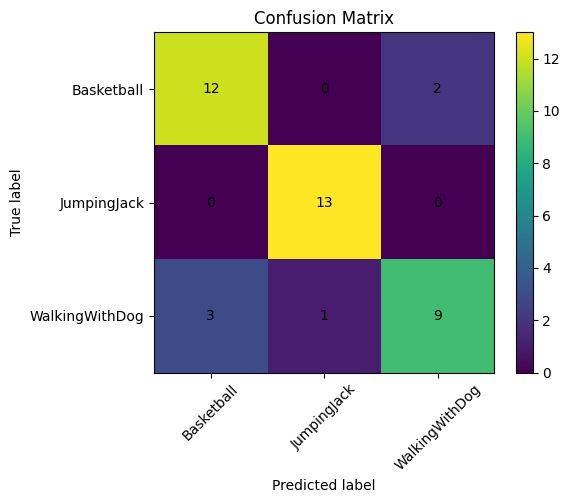

In [39]:
save_confusion_matrix(
    confusion_matrix(y_test, svm_preds),
    ["Basketball", "JumpingJack", "WalkingWithDog"],
    "svm_confusion_matrix.png"
)


The SVM classifier achieved strong performance using classical features.
Grid search identified an RBF kernel with C=10 as the best configuration.

The model achieved 90% accuracy on the test set, with the JumpingJack
class being classified perfectly. Minor confusion exists between
Basketball and WalkingWithDog due to similarities in motion patterns.

These results demonstrate that hand-crafted spatial and motion features
can be effective for action recognition tasks.


### Random Forest Classifier


RF Accuracy: 0.525
RF Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.57      0.59        14
           1       0.57      0.62      0.59        13
           2       0.38      0.38      0.38        13

    accuracy                           0.53        40
   macro avg       0.52      0.52      0.52        40
weighted avg       0.53      0.53      0.53        40

RF Confusion Matrix:
 [[8 2 4]
 [1 8 4]
 [4 4 5]]


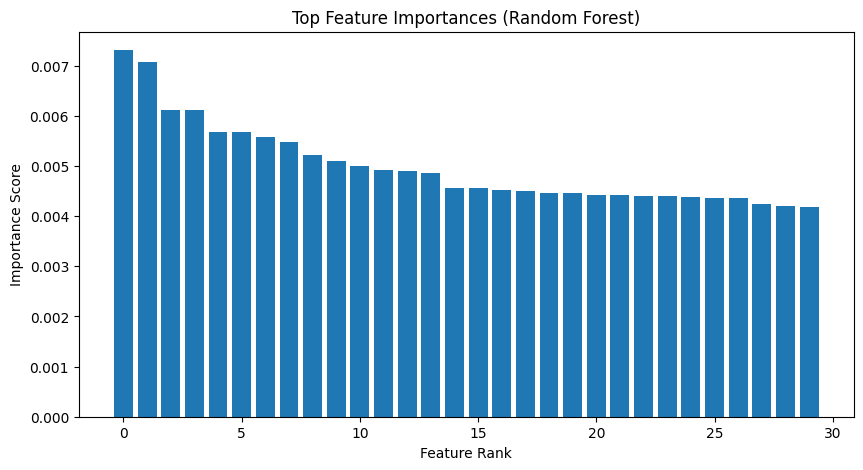

In [40]:

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, rf_preds))
print("RF Classification Report:\n", classification_report(y_test, rf_preds))
print("RF Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))


importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 30
plt.figure(figsize=(10, 5))
plt.title("Top Feature Importances (Random Forest)")
plt.bar(range(top_k), importances[indices[:top_k]])
plt.xlabel("Feature Rank")
plt.ylabel("Importance Score")
plt.savefig(
    "results/feature_visualizations/top_feature_importance.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()


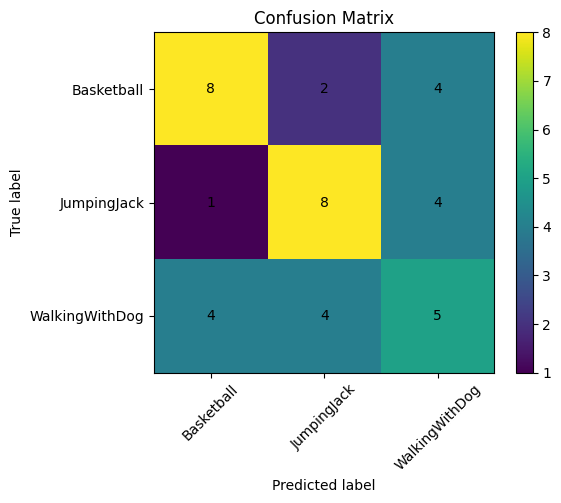

In [41]:
save_confusion_matrix(
    confusion_matrix(y_test, rf_preds),
    ["Basketball", "JumpingJack", "WalkingWithDog"],
    "rf_confusion_matrix.png"
)


The Random Forest classifier achieved lower performance compared to SVM,
with an accuracy of approximately 50%.

This is likely due to the high-dimensional histogram-based feature
representation, where individual features do not provide strong decision
boundaries for tree-based models.

The feature importance distribution shows that importance values are
relatively uniform across features, indicating that no single feature
dominates the classification decision.

This highlights a limitation of classical feature representations when
used with tree-based models


### Logistic Regression Model

### Logistic Regression Hyperparameter Tuning

The regularization strength (C) for Logistic Regression is tuned using the
validation set.

Different values of C are tested to observe how regularization affects
model performance. The model is trained on the training set and evaluated
on the validation set for each value of C.

The plot below shows validation accuracy as a function of C.


Tuning Logistic Regression hyperparameter C...


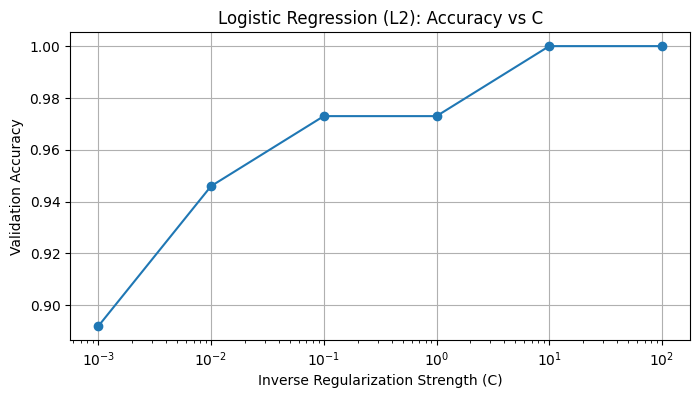

In [43]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
l2_accuracies = []

for C in C_values:
    lr = LogisticRegression(
        C=C,
        penalty="l2",
    solver="lbfgs",
        max_iter=1000
    )

    lr.fit(X_train_scaled, y_train)
    y_pred = lr.predict(X_val_scaled)

    acc = accuracy_score(y_val, y_pred)
    l2_accuracies.append(acc)

print("Tuning Logistic Regression hyperparameter C...")

plt.figure(figsize=(8, 4))
plt.semilogx(C_values, l2_accuracies, marker="o")
plt.xlabel("Inverse Regularization Strength (C)")
plt.ylabel("Validation Accuracy")
plt.title("Logistic Regression (L2): Accuracy vs C")
plt.grid(True)

plt.savefig(
    f"{performanceplots_dir}/logistic_regression_validation_curve.png",
    dpi=200,
    bbox_inches="tight"
)

plt.show()


From the validation curve, accuracy improves as regularization weakens
and stabilizes after C = 0.1. Therefore, C = 0.1 is selected as the
best hyperparameter value for the final model.


### Final Logistic Regression Model

Using the best hyperparameter value (C = 0.1), Logistic Regression is
trained again using the training data and evaluated on the test set.

This ensures that hyperparameter tuning is performed separately from
final model evaluation, preventing data leakage.


In [44]:

print("Training final Logistic Regression model...")

best_C = C_values[np.argmax(l2_accuracies)]
print("Best C:", best_C)

best_lr = LogisticRegression(
    C=best_C,
    penalty="l2",
    solver="lbfgs",
    max_iter=1000
)

best_lr.fit(X_train_scaled, y_train)
lr_preds = best_lr.predict(X_test_scaled)


print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print("LR Classification Report:\n", classification_report(y_test, lr_preds))
print("LR Confusion Matrix:\n", confusion_matrix(y_test, lr_preds))


Training final Logistic Regression model...
Best C: 10
Logistic Regression Accuracy: 0.9
LR Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.87      1.00      0.93        13
           2       0.85      0.85      0.85        13

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.91      0.90      0.90        40

LR Confusion Matrix:
 [[12  0  2]
 [ 0 13  0]
 [ 0  2 11]]


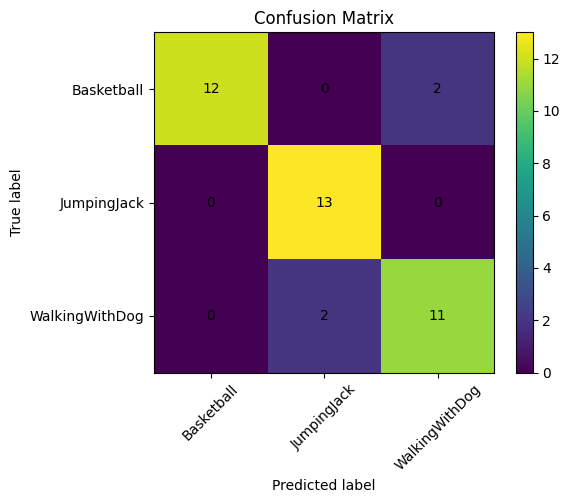

In [45]:
save_confusion_matrix(
    confusion_matrix(y_test, lr_preds),
    ["Basketball", "JumpingJack", "WalkingWithDog"],
    "lr_confusion_matrix.png"
)


## Classical Model Comparison

Three classical machine learning models were evaluated using the
hand-crafted video feature representation.

Test accuracies:
- Support Vector Machine (SVM): ~90%
- Random Forest: ~50%
- Logistic Regression: ~90%

SVM and Logistic Regression performed significantly better than
Random Forest. This suggests that the histogram-based feature
representation is well-suited for linear and margin-based classifiers,
but less effective for tree-based ensemble methods.

Random Forest performance was lower because feature importance values
were distributed across many features, making it difficult for decision
trees to identify strong split points.

These results highlight both the strengths and limitations of classical
feature engineering approaches for video classification.
